In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_val_score, 
    GridSearchCV,
    StratifiedKFold,
    RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, 
    classification_report, 
    make_scorer,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    matthews_corrcoef,
    precision_recall_curve,
    roc_curve, 
    auc,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_curve, auc

In [2]:
train_df = pd.read_csv('combined_train_with_labels.csv.gz')
train_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2120.0,-635333.796311,...,65.0,85.0,0.142357,3,1.198436,0.059642,0.519805,1.000000,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2004.0,-289756.893085,...,60.0,87.0,0.151160,3,1.381123,0.061975,0.531775,1.000000,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2125.0,-379843.029134,...,67.0,95.0,0.142606,3,1.361857,0.050813,0.343676,1.000000,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2098.0,-252673.626844,...,90.0,116.0,0.133192,2,1.165654,0.062954,0.483144,1.000000,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2037.0,-317761.453582,...,61.0,94.0,0.145504,7,1.390918,0.055013,0.377738,1.000000,53.0,0.035971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-240759.341995,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,33.442724,69.0,0.035228
1039996,1039996_train_15,380.170340,True,True,True,True,949,3404.0,2045.0,-417622.302428,...,57.0,79.0,0.150305,3,1.245492,0.062706,0.564955,58.862967,71.0,0.034669
1039997,1039997_train_15,370.109563,False,True,True,True,947,3409.0,2063.0,-407730.168602,...,77.0,102.0,0.142950,2,1.149456,0.062153,0.473789,143.746154,79.0,0.034553
1039998,1039998_train_15,98.258524,True,True,True,False,921,3400.0,2001.0,-116570.568893,...,71.0,92.0,0.153135,5,1.192639,0.065264,0.572606,1.000000,42.0,0.039377


In [3]:
test_df = pd.read_csv('combined_test_with_labels.csv.gz')
test_df

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,2395098_test_0,1167.174731,True,True,True,True,967,3407.0,2036.0,-1.300536e+06,...,55.0,76.0,0.148591,1,1.282821,0.062497,0.553581,2.257453e+02,69.0,0.034373
1,2395099_test_0,870.765543,False,True,True,False,960,3405.0,2019.0,-9.729822e+05,...,70.0,90.0,0.147334,1,1.203640,0.063886,0.573090,2.120524e+12,88.0,0.034307
2,2395100_test_0,582.980526,False,True,True,True,960,3412.0,2107.0,-6.390870e+05,...,76.0,100.0,0.139090,2,1.189320,0.057715,0.443685,1.784824e+02,84.0,0.034885
3,2395101_test_0,238.918902,True,True,True,True,930,3408.0,2053.0,-2.760460e+05,...,88.0,110.0,0.138597,2,1.226275,0.067184,0.583046,1.000000e+00,53.0,0.035474
4,2395102_test_0,214.491195,False,True,True,True,924,3406.0,1939.0,-7.611188e+04,...,83.0,135.0,0.149185,13,1.203153,0.055602,0.403248,1.000000e+00,46.0,0.051582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389995,2785093_test_5,238.472881,False,True,True,False,940,3406.0,2081.0,-2.667054e+05,...,69.0,111.0,0.144375,2,1.198436,0.062338,0.518905,1.000000e+00,73.0,0.034997
389996,2785094_test_5,452.840234,True,True,True,True,952,3406.0,2058.0,-5.194853e+05,...,59.0,83.0,0.148058,3,2.268535,0.064586,0.590262,5.597816e+01,54.0,0.035930
389997,2785095_test_5,344.740556,True,True,True,True,948,3406.0,2036.0,-3.684673e+05,...,80.0,125.0,0.140774,3,1.217066,0.062375,0.536752,1.000000e+00,82.0,0.034713
389998,2785096_test_5,163.807547,True,True,True,True,925,3406.0,2067.0,-1.903450e+05,...,94.0,116.0,0.140754,2,0.975055,0.066704,0.577498,1.000000e+00,41.0,0.036159


In [4]:
label_cols = [
    "psd_label_lq",
    "psd_label_high_avse",
    "psd_label_low_avse",
    "psd_label_dcr",
    "energy_label",
]

feature_cols = [col for col in train_df.columns if col not in label_cols + ['id']]

In [5]:
# Filter rows where ALL of these columns are True
# .all(axis=1) checks if every column in the list is True for that row
matching_rows = train_df[train_df[label_cols].all(axis=1)]
matching_rows

,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,tdrift50,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
5,5_train_0,202.118818,True,True,True,True,938,3401.0,2016.0,-2.238298e+05,...,62.0,86.0,0.148161,2,1.333229,0.066141,0.588104,2.991743e+01,39.0,0.048042
6,6_train_0,855.765685,True,True,True,True,953,3413.0,2110.0,-9.533368e+05,...,88.0,106.0,0.136972,1,1.463301,0.061205,0.528196,1.570316e+02,93.0,0.034815
8,8_train_0,1212.688940,True,True,True,True,961,3412.0,2089.0,-1.336303e+06,...,82.0,105.0,0.140185,1,1.217066,0.065910,0.591604,1.603469e+02,92.0,0.034293
11,11_train_0,2334.785962,True,True,True,True,961,3412.0,2061.0,-2.494320e+06,...,92.0,117.0,0.139700,1,1.488288,0.062823,0.566847,5.637905e+12,109.0,0.034266
14,14_train_0,2130.987393,True,True,True,True,980,3401.0,2057.0,-2.373392e+06,...,21.0,43.0,0.157380,1,2.648069,0.072427,0.639669,5.235714e+12,48.0,0.033637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039985,1039985_train_15,238.270546,True,True,True,True,966,3401.0,2024.0,-2.676853e+05,...,26.0,77.0,0.164503,2,1.653406,0.070927,0.611792,3.050746e+01,42.0,0.034336
1039986,1039986_train_15,230.961021,True,True,True,True,929,3408.0,2032.0,-2.581743e+05,...,94.0,116.0,0.138498,1,1.165428,0.069788,0.606824,8.871756e+01,64.0,0.034692
1039990,1039990_train_15,299.894902,True,True,True,True,932,3407.0,2021.0,-3.529948e+05,...,84.0,119.0,0.138221,4,1.135231,0.066935,0.584033,1.000000e+00,52.0,0.034463
1039995,1039995_train_15,210.834626,True,True,True,True,949,3403.0,2048.0,-2.407593e+05,...,55.0,90.0,0.151747,6,1.008092,0.062825,0.573645,3.344272e+01,69.0,0.035228


# MODEL TRAINING

## Model Training - psd_label_high_avse

In [6]:
len(feature_cols)

27

In [7]:
feature_cols

['tp0',
 'ED',
 'HWP',
 'LQ80',
 'PPR',
 'SCA',
 'ND80',
 'current_skewness',
 'tail_slope_no_pz',
 'spectral_centroid_power',
 'current_kurtosis',
 'tail_slope',
 'total_power',
 'time_to_main_peak',
 'time_to_peak',
 'current_width',
 'tdrift10',
 'tdrift50',
 'tdrift99',
 'tfr',
 'peak_count',
 'gbn',
 'bpr',
 'AvsE',
 'GradAreaRatio',
 'GradWidthMain',
 'HFER']

In [8]:
pd.concat([train_df["psd_label_high_avse"].value_counts(), 
           train_df["psd_label_high_avse"].value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,1031559,0.991884
False,8441,0.008116


In [9]:
pd.concat([test_df["psd_label_high_avse"].value_counts(), 
           test_df["psd_label_high_avse"].value_counts(normalize=True)], axis=1)

,count,proportion
psd_label_high_avse,,
True,386840,0.991897
False,3160,0.008103


In [18]:
# DATA PREP
X_train = train_df[feature_cols]
y_train = train_df["psd_label_high_avse"]

X_test = test_df[feature_cols]
y_test = test_df["psd_label_high_avse"]

In [15]:
X.isna().sum().sort_values(ascending=False)

tdrift99                   5
tdrift50                   5
tdrift10                   5
tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

In [32]:
X_test_final.isna().sum().sort_values(ascending=False)

tp0                        0
time_to_peak               0
GradWidthMain              0
GradAreaRatio              0
AvsE                       0
bpr                        0
gbn                        0
peak_count                 0
tfr                        0
tdrift99                   0
tdrift50                   0
tdrift10                   0
current_width              0
time_to_main_peak          0
ED                         0
total_power                0
tail_slope                 0
current_kurtosis           0
spectral_centroid_power    0
tail_slope_no_pz           0
current_skewness           0
ND80                       0
SCA                        0
PPR                        0
LQ80                       0
HWP                        0
HFER                       0
dtype: int64

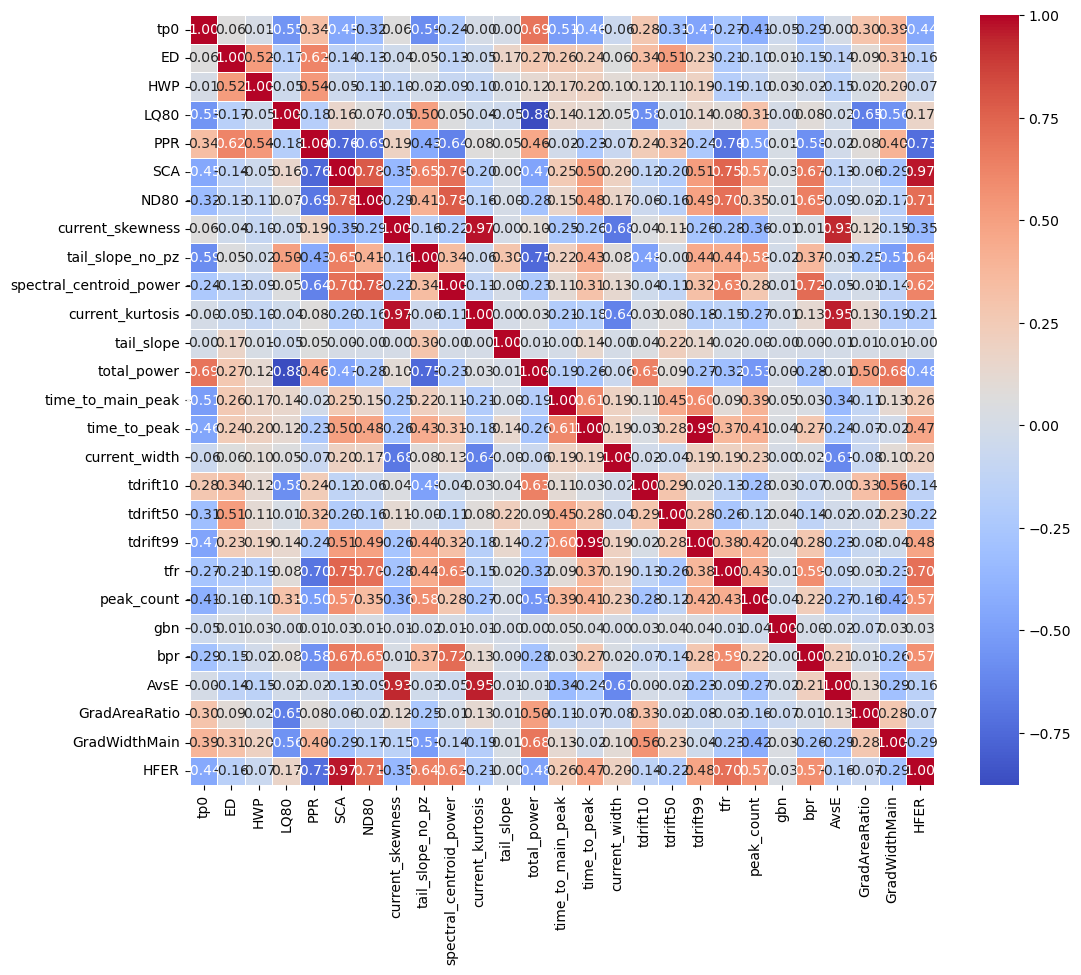

In [16]:
correlation_matrix = pd.DataFrame(X).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True,cmap='coolwarm',fmt=".2f", linewidths=.5)
plt.show()

### DEFINE CUSTOM SCORERS (For Tuning)

In [7]:
# ==========================================
# 0. DEFINE CUSTOM SCORERS (For Tuning)
# ==========================================
# We wrap these in make_scorer so RandomizedSearchCV can track counts
def tn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[0]
def fp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[1]
def fn_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[2]
def tp_score(y_true, y_pred): return confusion_matrix(y_true, y_pred).ravel()[3]

scoring_metrics = {
    'MCC': make_scorer(matthews_corrcoef),
    'AUC_PR': make_scorer(average_precision_score, response_method="predict_proba"),
    'AUC_ROC': make_scorer(roc_auc_score, response_method="predict_proba"),
    'Class0_F1': make_scorer(f1_score, pos_label=0), 
    'Class1_F1': make_scorer(f1_score, pos_label=1),
    'TN': make_scorer(tn_score),
    'FP': make_scorer(fp_score),
    'FN': make_scorer(fn_score),
    'TP': make_scorer(tp_score)
}

# Define the columns you want to keep
cols_to_show = [
    'params',
    'mean_test_MCC', 
    'mean_test_AUC_PR', 
    'mean_test_AUC_ROC',
    'mean_test_Class0_F1',
    'mean_test_Class1_F1',
    'mean_test_TN', 'mean_test_FP', # Class 0 Performance
    'mean_test_TP', 'mean_test_FN', # Class 1 Performance
]

### Baseline Logistic Regression

In [8]:
# Baseline performance
pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

In [24]:
# Train
pipe_baseline.fit(X_train, y_train)

# Predict 
y_pred_baseline = pipe_baseline.predict(X_test)

              precision    recall  f1-score   support

       False       0.08      0.87      0.15      1688
        True       1.00      0.92      0.96    206312

    accuracy                           0.92    208000
   macro avg       0.54      0.90      0.56    208000
weighted avg       0.99      0.92      0.95    208000

AUC-PR Score: 0.9995
(Baseline/Random would be: 0.9919)
MCC Score: 0.2563


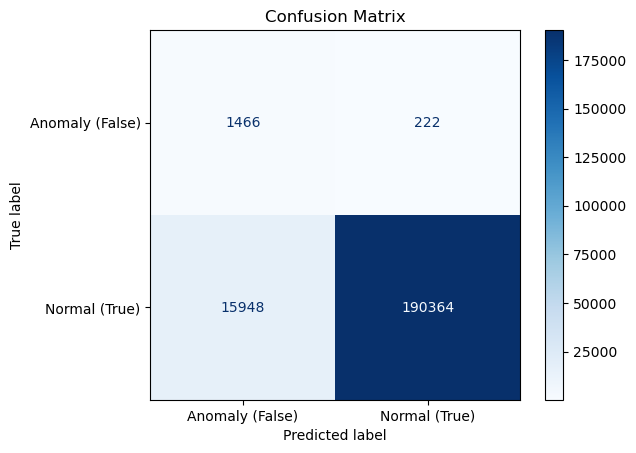

AUC Score: 0.9592


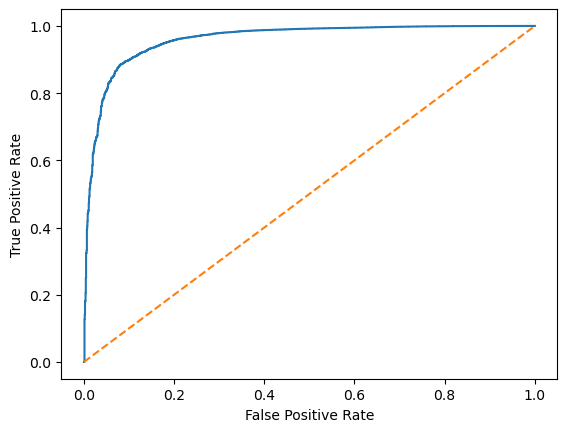

In [25]:
# Evaluate
# main classification metrics
print(classification_report(y_test, y_pred_baseline))

# 1. Get predicted probabilities (NOT just labels)
# usage: model.predict_proba(X_test) gives [prob_class_0, prob_class_1]
# We usually want the probability of the positive class (index 1)
y_probs = pipe_baseline.predict_proba(X_test)[:, 1]

# AUC-PR
auc_pr = average_precision_score(y_test, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred_baseline)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 2. Calculate FPR, TPR, and Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# 3. Calculate the AUC score
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

# Optional: Plotting
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [26]:
# 1. Extract Coefficients and Feature Names
# new_model.coef_[0] holds the weights for the features
coefficients2 = pipe_baseline.named_steps['lr'].coef_[0]

# 2. Create a DataFrame for sorting
feat_imp2 = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients2,
    'Importance': abs(coefficients2) # We sort by the absolute value (magnitude)
})

# 3. Sort by Importance (Highest magnitude at the top)
feat_imp2 = feat_imp2.sort_values(by='Importance', ascending=False)

# Optional: Print the top 5 most influential features
print("\nFeature Importance Ranking")
print(feat_imp2[['Feature', 'Coefficient']])


Feature Importance Ranking
                    Feature  Coefficient
12              total_power    -3.223971
10         current_kurtosis     3.006055
23                     AvsE    -2.992869
14             time_to_peak    -2.000759
8          tail_slope_no_pz    -1.644109
3                      LQ80    -1.221831
17                 tdrift50     1.113294
25            GradWidthMain     0.951627
5                       SCA     0.884573
1                        ED    -0.673119
26                     HFER    -0.619054
16                 tdrift10     0.522222
7          current_skewness    -0.501031
13        time_to_main_peak     0.422777
11               tail_slope     0.417702
19                      tfr    -0.392097
4                       PPR     0.239959
0                       tp0    -0.180369
6                      ND80     0.098065
21                      gbn     0.062476
18                 tdrift99     0.054496
22                      bpr    -0.044665
24            GradAreaRatio  

### Optimizing Logistic Regression (hyperparamter tunning)

In [10]:
# HYPERPARAMETER TUNING (Find the Best Version)
# tune the 'lr' (Logistic Regression) part of the pipe
param_grid = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__class_weight': [
        'balanced', 
        {0:1, 1:5},   # Mild imbalance
        {0:1, 1:10},  # Moderate
        {0:1, 1:20},  # Strong (common in detector data)
        {0:1, 1:100}, # Extreme (rare event search)
        None          # Baseline (equal weight)
    ]
}

# Use Standard Stratified K-Fold for speed during the search
grid = GridSearchCV(
    estimator=pipe_baseline,        
    param_grid=param_grid, 
    cv=StratifiedKFold(n_splits=5), 
    scoring=scoring_metrics,
    refit='MCC',
    n_jobs=-1,
    verbose=1
)

print("Tuning hyperparameters...")
grid.fit(X_train, y_train) # runs the internal CV loops

Tuning hyperparameters...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__class_weight': ['balanced', {0: 1, 1: 5},
                                              {0: 1, 1: 10}, {0: 1, 1...
                      'Class1_F1': make_scorer(f1_score, response_method='predict', pos_label=1),
                      'FN': make_scorer(fn_score, response_method='predict'),
                      'FP': make_scorer(fp_score, response_method='predict'),
                      'MCC': make_scorer(matthews_corrcoef, response_method='predict'),
                      'TN': make_scorer(tn_score, response_method='predict'),
                      'TP': make_scorer(tp_score, response_method='predict')},
             verbose=1)

In [15]:
# RESULTS VISUALIZATION
# Convert the results dictionary to a DataFrame
cv_results = grid.cv_results_
results_df = pd.DataFrame(cv_results)

pd.set_option('display.max_colwidth', None) # Show full param dict

# Create a clean view sorted by best performance
clean_results = results_df.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]
clean_results

,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN,params
29,0.355866,0.999198,0.937569,0.295960,0.996325,256.0,1094.6,164927.2,122.2,"{'lr__C': 100, 'lr__class_weight': None}"
17,0.355358,0.999190,0.937028,0.295658,0.996322,255.8,1094.8,164926.4,123.0,"{'lr__C': 1, 'lr__class_weight': None}"
11,0.354793,0.999196,0.937421,0.294407,0.996323,254.2,1096.4,164928.4,121.0,"{'lr__C': 0.1, 'lr__class_weight': None}"
23,0.354759,0.999188,0.937582,0.295579,0.996317,256.0,1094.6,164924.8,124.6,"{'lr__C': 10, 'lr__class_weight': None}"
5,0.351549,0.999207,0.935551,0.288347,0.996324,246.8,1103.8,164936.0,113.4,"{'lr__C': 0.01, 'lr__class_weight': None}"
0,0.257866,0.999561,0.960236,0.154214,0.959198,1180.8,169.8,152265.4,12784.0,"{'lr__C': 0.01, 'lr__class_weight': 'balanced'}"
6,0.257426,0.999558,0.960184,0.153619,0.958946,1182.4,168.2,152186.8,12862.6,"{'lr__C': 0.1, 'lr__class_weight': 'balanced'}"
24,0.257367,0.999558,0.960168,0.153520,0.958899,1182.8,167.8,152172.2,12877.2,"{'lr__C': 100, 'lr__class_weight': 'balanced'}"
18,0.257333,0.999558,0.960169,0.153508,0.958902,1182.6,168.0,152173.4,12876.0,"{'lr__C': 10, 'lr__class_weight': 'balanced'}"
12,0.257306,0.999558,0.960162,0.153482,0.958894,1182.6,168.0,152170.8,12878.6,"{'lr__C': 1, 'lr__class_weight': 'balanced'}"


In [17]:
# Get the best model
best_model = grid.best_estimator_
print(f"Best Params found: {grid.best_params_}")
print(f"Mean MCC: {grid.best_score_}")

# Extract the Logistic Regression step and its coefficients
coefficients = best_model.named_steps['lr'].coef_[0]

# Create df
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Importance': abs(coefficients)
})

# Sort by Absolute Importance (biggest impact at the top)
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# REPORTING (TEXT)
# Use an option context to force Pandas to print the WHOLE list, not just top/bottom
print(f"\n--- FULL FEATURE RANKING: Impact of All {len(feature_importance)} Features on High AVSE ---")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance[['Feature', 'Coefficient']])

Best Params found: {'lr__C': 100, 'lr__class_weight': None}
Mean MCC: 0.35586643783047484

--- FULL FEATURE RANKING: Impact of All 27 Features on High AVSE ---
                    Feature  Coefficient
12              total_power    -2.517754
25            GradWidthMain     1.504171
23                     AvsE    -1.100981
8          tail_slope_no_pz    -1.092617
10         current_kurtosis     0.923102
3                      LQ80    -0.738207
14             time_to_peak    -0.619357
5                       SCA     0.546358
17                 tdrift50     0.458855
16                 tdrift10     0.428897
26                     HFER    -0.352698
4                       PPR     0.338956
7          current_skewness    -0.177783
11               tail_slope     0.173705
19                      tfr    -0.152369
6                      ND80     0.130961
20               peak_count     0.114194
21                      gbn     0.083046
24            GradAreaRatio    -0.073735
13        time_to_ma


Final Test Set Performance (20% Hold-out):
              precision    recall  f1-score   support

       False       0.47      0.42      0.44      1688
        True       1.00      1.00      1.00    206312

    accuracy                           0.99    208000
   macro avg       0.73      0.71      0.72    208000
weighted avg       0.99      0.99      0.99    208000

AUC-PR Score: 0.9994
(Baseline/Random would be: 0.9919)
MCC Score: 0.4401


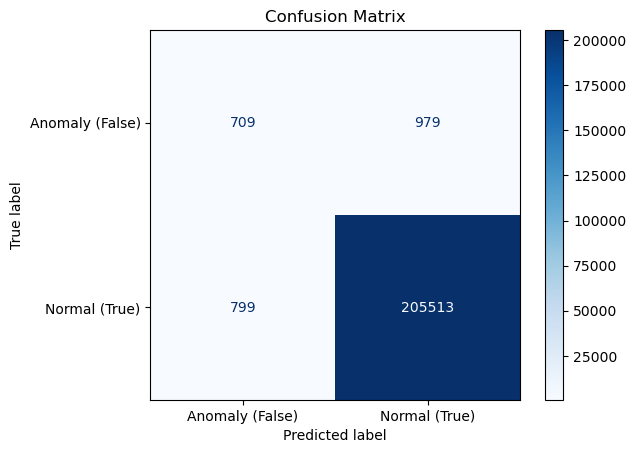

In [35]:
# EVALUATION
print("\nFinal Test Set Performance (20% Hold-out):")
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# We need probabilities, not just predictions, for the curve
y_probs = best_model.predict_proba(X_test)[:, 1] # Prob of class 0 (False/Anomaly)

# AUC-PR
auc_pr = average_precision_score(y_test, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Drop Features


Final Test Set Performance (Dropped: ['time_to_main_peak', 'tp0', 'tail_slope', 'spectral_centroid_power']):
              precision    recall  f1-score   support

       False       0.08      0.87      0.15      1688
        True       1.00      0.92      0.96    206312

    accuracy                           0.92    208000
   macro avg       0.54      0.89      0.55    208000
weighted avg       0.99      0.92      0.95    208000

AUC-PR Score: 0.3517
(Baseline/Random would be: 0.0081)
MCC Score: 0.2530


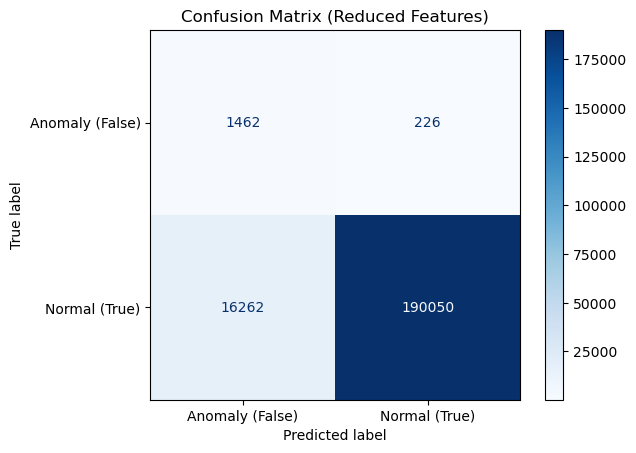

In [23]:
# 1. DROP FEATURES
# Assuming 'X' is your original feature set and 'y' is your target
cols_to_drop = ["time_to_main_peak", "tp0", "tail_slope", "spectral_centroid_power"]

# Create the new reduced feature set
drop_least_df = X.drop(columns=cols_to_drop, errors='ignore')

# 2. RE-SPLIT DATA
# We must create new test sets because the features have changed
X_train_new, X_test_new, y_train, y_test = train_test_split(
    drop_least_df, y, test_size=0.2, random_state=42, stratify=y
)

# 3. RE-TRAIN MODEL
# You must initialize and fit a new model on the reduced data
new_model = pipe_baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])
new_model.fit(X_train_new, y_train)

# 4. EVALUATION
print(f"\nFinal Test Set Performance (Dropped: {cols_to_drop}):")

# Generate predictions with the NEW model
y_pred = new_model.predict(X_test_new)
print(classification_report(y_test, y_pred))

# Prepare for AUC-PR (Anomaly Detection often treats the Minority/False class as 'Positive' for detection)
# This logic assumes your Normal data is True and Anomalies are False
y_test_flipped = (~y_test) 

# Get probabilities for the class that represents Anomalies (Class 0 / False)
y_probs = new_model.predict_proba(X_test_new)[:, 0] 

# AUC-PR
auc_pr = average_precision_score(y_test_flipped, y_probs)
print(f"AUC-PR Score: {auc_pr:.4f}")
print(f"(Baseline/Random would be: {y_test_flipped.mean():.4f})")

# MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC Score: {mcc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
# Note: Ensure labels match your boolean logic (False=Anomaly, True=Normal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly (False)', 'Normal (True)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Reduced Features)")
plt.show()

In [24]:
# 1. Extract Coefficients and Feature Names
# new_model.coef_[0] holds the weights for the features
coefficients = new_model.named_steps['lr'].coef_[0]
feature_names = drop_least_df.columns

# 2. Create a DataFrame for sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients) # We sort by the absolute value (magnitude)
})

# 3. Sort by Importance (Highest magnitude at the top)
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Optional: Print the top 5 most influential features
print("\nFeature Importance Ranking")
print(feat_imp[['Feature', 'Coefficient']])


Feature Importance Ranking
             Feature  Coefficient
19              AvsE    -3.480868
8   current_kurtosis     3.367151
9        total_power    -3.290821
10      time_to_peak    -1.543151
7   tail_slope_no_pz    -1.500826
2               LQ80    -1.169060
13          tdrift50     1.162887
4                SCA     1.144878
21     GradWidthMain     1.010371
0                 ED    -0.948305
22              HFER    -0.778712
12          tdrift10     0.646991
3                PPR     0.494615
15               tfr    -0.426822
6   current_skewness    -0.380267
16        peak_count     0.176287
5               ND80     0.154611
14          tdrift99    -0.093020
1                HWP    -0.089646
11     current_width     0.071463
18               bpr    -0.065837
17               gbn     0.064245
20     GradAreaRatio     0.055677


### XGBoost

In [18]:
# ==========================================
# 1. SETUP & IMBALANCE HANDLING
# ==========================================
# Calculate Ratio: (Count of 0) / (Count of 1)
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
print(f"Baseline Imbalance Ratio (Neg/Pos): {ratio:.5f}")

# The Parameter Grid
param_grid = {
    'scale_pos_weight': [ratio, ratio * 0.5, ratio * 2], 
    'max_depth': [3, 4, 5, 6],           
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'n_estimators': [200, 500, 1000],    
    'gamma': [0, 0.1, 1.0],              
    'max_delta_step': [0, 1, 5],         
    'subsample': [0.7, 0.9, 1.0],        
    'colsample_bytree': [0.7, 0.9, 1.0]  
}

# The Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

Baseline Imbalance Ratio (Neg/Pos): 0.00818


In [17]:
# ==========================================
# 2. HYPERPARAMETER TUNING (The Search)
# ==========================================
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring_metrics,  # <--- Tracks ALL metrics defined above
    refit='MCC',           # <--- Optimizes specifically for Precision-Recall Area
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting Hyperparameter Tuning...")
search.fit(X_train, y_train)

# Get the winner
best_xgb = search.best_estimator_
print(f"\nBest Params: {search.best_params_}")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

>>> TOP 5 MODELS (Based on AUC_PR) <<<
    mean_test_MCC  mean_test_AUC_PR  mean_test_AUC_ROC  mean_test_Class0_F1  mean_test_TN  mean_test_FP  mean_test_TP  mean_test_FN                                             params
1        0.564236          0.999965           0.995920             0.500682        1289.0          61.6      162539.6        2509.8  {'subsample': 1.0, 'scale_pos_weight': 0.00409...
8        0.606816          0.999965           0.995961             0.561031        1254.6          96.0      163181.4        1868.0  {'subsample': 0.9, 'scale_pos_weight': 0.01636...
9        0.522005          0.999955           0.994785             0.447764        1283.8          66.8      161948.8        3100.6  {'subsample': 0.9, 'scale_pos_weight': 0.01636...
18       0.462259          0.999955           0.994672             0.367255        1312.8          37.8      160563.0        4486.4 

In [12]:
# ==========================================
# 3. STORE AND DISPLAY RESULTS
# ==========================================
print("\n>>> TOP 5 MODELS (Based on AUC_PR) <<<")

# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search.cv_results_)

# 3. Sort, Filter, and Store in a new DataFrame variable
top_models_df = results.sort_values(by='mean_test_AUC_PR', ascending=False)[cols_to_show]

# 4. Display the stored DataFrame
top_models_df.head()


>>> TOP 5 MODELS (Based on AUC_PR) <<<


,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN,params
7,0.611570,0.999933,0.993596,0.609298,0.997166,1216.666667,1034.333333,274556.333333,526.000000,"{'n_estimators': 200, 'min_samples_split': 10,..."
1,0.540278,0.999932,0.992192,0.494290,0.992785,1927.333333,323.666667,271460.333333,3622.000000,"{'n_estimators': 200, 'min_samples_split': 5, ..."
19,0.532699,0.999920,0.991097,0.486041,0.992590,1914.666667,336.333333,271367.000000,3715.333333,"{'n_estimators': 100, 'min_samples_split': 5, ..."
0,0.586061,0.999911,0.992369,0.572612,0.997165,1046.666667,1204.333333,274724.333333,358.000000,"{'n_estimators': 200, 'min_samples_split': 5, ..."
5,0.545150,0.999903,0.989254,0.509509,0.997067,840.000000,1411.000000,274876.333333,206.000000,"{'n_estimators': 500, 'min_samples_split': 5, ..."


In [24]:
# ==========================================
# 4. THRESHOLD TUNING (The Calibration)
# ==========================================
print("\n>>> TUNING THRESHOLD ON TEST SET <<<")
y_proba = best_xgb.predict_proba(X_test)[:, 1]

# Constant metrics (Independent of threshold)
model_auc_pr = average_precision_score(y_test, y_proba)
model_auc_roc = roc_auc_score(y_test, y_proba)

threshold_results = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

for thresh in thresholds:
    # Apply Threshold
    y_pred_loop = (y_proba >= thresh).astype(int)
    
    # Calculate Counts
    cm = confusion_matrix(y_test, y_pred_loop)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate Scores
    threshold_results.append({
        'Threshold': thresh,
        'MCC': matthews_corrcoef(y_test, y_pred_loop),
        'AUC_PR': model_auc_pr,   # Constant
        'AUC_ROC': model_auc_roc, # Constant
        'Class0_F1': f1_score(y_test, y_pred_loop, pos_label=0),
        'Class1_F1': f1_score(y_test, y_pred_loop, pos_label=1),
        'TN (True 0)': tn,
        'FP (Wrongly 1)': fp,
        'FN (Wrongly 0)': fn,
        'TP (True 1)': tp
    })

# Display Threshold Table
thresh_df = pd.DataFrame(threshold_results)
thresh_df.sort_values(by='MCC', ascending=False)


>>> TUNING THRESHOLD ON TEST SET <<<


,Threshold,MCC,AUC_PR,AUC_ROC,Class0_F1,Class1_F1,TN (True 0),FP (Wrongly 1),FN (Wrongly 0),TP (True 1)
0,0.50,0.561822,0.999968,0.996167,0.497454,0.992047,1612,76,3181,203131
1,0.60,0.543418,0.999968,0.996167,0.471303,0.991060,1630,58,3599,202713
2,0.70,0.519107,0.999968,0.996167,0.438283,0.989684,1644,44,4170,202142
3,0.80,0.488357,0.999968,0.996167,0.397695,0.987696,1656,32,4984,201328
4,0.90,0.438767,0.999968,0.996167,0.335077,0.983727,1665,23,6585,199727
5,0.95,0.393153,0.999968,0.996167,0.279178,0.978551,1678,10,8655,197657
6,0.99,0.295648,0.999968,0.996167,0.173546,0.959558,1684,4,16035,190277


In [25]:
# ==========================================
# 5. FINAL REPORT (Production Ready)
# ==========================================
# Automatically select best threshold based on MCC
best_row = thresh_df.loc[thresh_df['MCC'].idxmax()]
best_threshold = best_row['Threshold']

print(f"\n" + "="*40)
print(f" FINAL MODEL CONFIGURATION")
print(f" Best Threshold: {best_threshold}")
print(f" Best MCC:       {best_row['MCC']:.4f}")
print("="*40)

# Final Predictions
y_final_pred = (y_proba >= best_threshold).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_final_pred)
print(f"True 0 (TN): {cm[0,0]}   False 0 (FN): {cm[1,0]}")
print(f"False 1 (FP): {cm[0,1]}   True 1 (TP): {cm[1,1]}")

print("\nFull Classification Report:")
print(classification_report(y_test, y_final_pred, digits=4))


 FINAL MODEL CONFIGURATION
 Best Threshold: 0.5
 Best MCC:       0.5618

Confusion Matrix:
True 0 (TN): 1612   False 0 (FN): 3181
False 1 (FP): 76   True 1 (TP): 203131

Full Classification Report:
              precision    recall  f1-score   support

       False     0.3363    0.9550    0.4975      1688
        True     0.9996    0.9846    0.9920    206312

    accuracy                         0.9843    208000
   macro avg     0.6680    0.9698    0.7448    208000
weighted avg     0.9942    0.9843    0.9880    208000




>>> FEATURE IMPORTANCE RANKING <<<
                    Feature  Importance
0                  tdrift50    0.221218
1                  tdrift99    0.127237
2                       tfr    0.125888
3              time_to_peak    0.125369
4         time_to_main_peak    0.085989
5                       bpr    0.038722
6                       SCA    0.024551
7             GradAreaRatio    0.021607
8          current_kurtosis    0.020722
9                       HWP    0.020134
10            GradWidthMain    0.019837
11                     AvsE    0.017191
12         current_skewness    0.016830
13                      PPR    0.016570
14                       ED    0.016529
15            current_width    0.013723
16               peak_count    0.012850
17  spectral_centroid_power    0.012371
18         tail_slope_no_pz    0.011491
19              total_power    0.009321
20                      tp0    0.008446
21                 tdrift10    0.008273
22                     LQ80    0.008040
23  

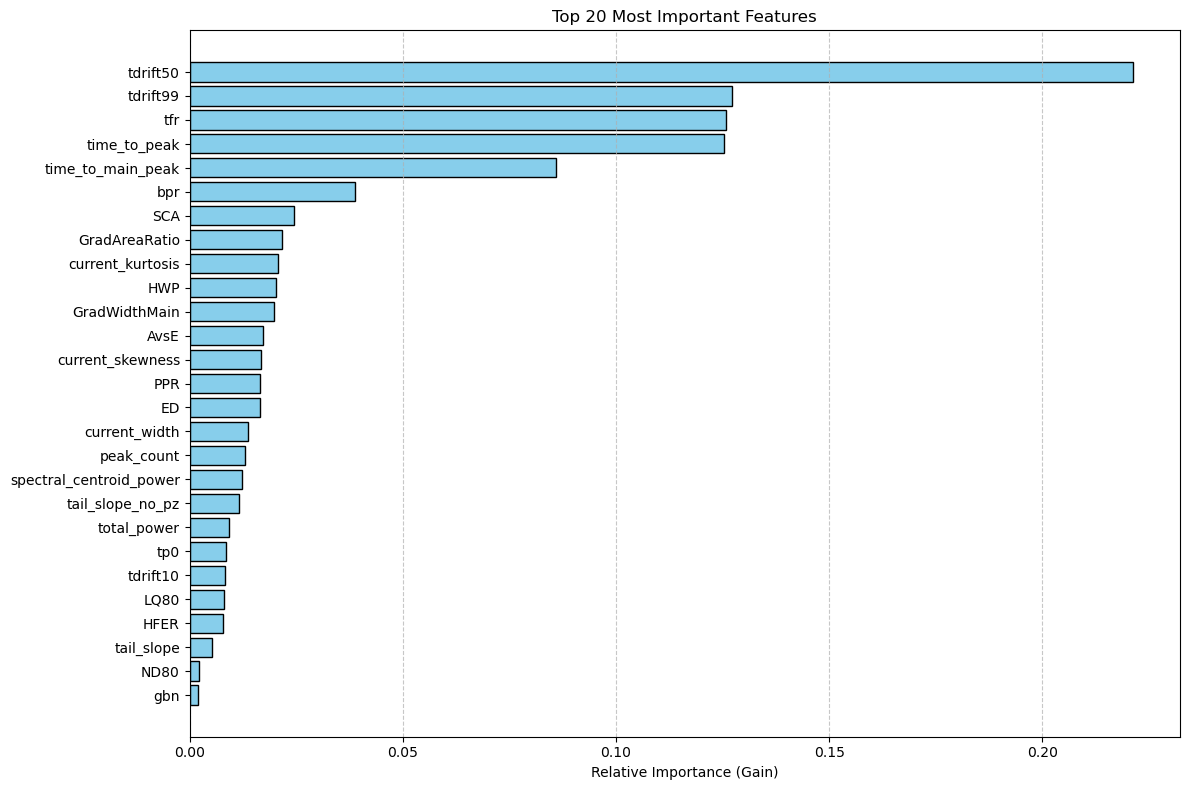

In [31]:
# ==========================================
# 1. EXTRACT IMPORTANCE
# ==========================================
# Get the feature names
feature_names = X_train.columns

# Get the raw importance scores
importances = best_model.feature_importances_

# Create a DataFrame for easy viewing
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance (Highest on top)
feature_df = feature_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the ranking as a table
print("\n>>> FEATURE IMPORTANCE RANKING <<<")
print(feature_df)

# ==========================================
# 2. VISUALIZE (Bar Chart)
# ==========================================
plt.figure(figsize=(12, 8))

plot_data = feature_df

# Create Bar Plot
plt.barh(plot_data['Feature'], plot_data['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Relative Importance (Gain)')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis() # Invert so the #1 feature is at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [26]:
# ==========================================
# 1. PREPARE FULL TRAINING DATA
# ==========================================
# We combine the previous Train and Test sets to give the final model 
# the maximum amount of data (crucial for the rare minority class).
print(f"Final Training Shape: {X.shape}")
print(f"Final Test Shape:     {X_test_final.shape}")

# ==========================================
# 2. RETRAIN MODEL WITH BEST PARAMS
# ==========================================
# We unpack the best parameters found by RandomizedSearchCV
final_model = xgb.XGBClassifier(
    **search.best_params_,  # Uses the winner from the previous step
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

print("\nRetraining model on full dataset...")
final_model.fit(X, y_train_full)

# ==========================================
# 3. PREDICT ON FINAL HELD-OUT SET
# ==========================================
# Get probabilities for the final test set
y_final_proba = final_model.predict_proba(X_test_final)[:, 1]

# Apply the BEST THRESHOLD found in the previous step
# (If you didn't run the loop, set this manually, e.g., best_threshold = 0.95)
print(f"\nApplying Best Threshold: {best_threshold}")
y_final_pred = (y_final_proba >= best_threshold).astype(int)

# ==========================================
# 4. FINAL PERFORMANCE REPORT
# ==========================================
print("\n" + "="*40)
print("FINAL REPORT (X_test_final)")
print("="*40)

# Confusion Matrix
cm = confusion_matrix(y_test_final, y_final_pred)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (Anomalies Caught): {tn}")
print(f"False Positives (False Alarms):    {fp}")
print(f"False Negatives (Missed Signal):   {fn}")
print(f"True Positives (Clean Signal):     {tp}")

# Calculate Final MCC
final_mcc = matthews_corrcoef(y_test_final, y_final_pred)
print(f"\nMatthews Correlation Coef (MCC):   {final_mcc:.4f}")

# Calculate Final AUC-PR (The most honest metric)
final_pr_auc = average_precision_score(y_test_final, y_final_proba)
print(f"Area Under PR Curve (AUC-PR):      {final_pr_auc:.4f}")

print("\nFull Classification Report:")
print(classification_report(y_test_final, y_final_pred))

Final Training Shape: (1040000, 27)
Final Test Shape:     (390000, 27)

Retraining model on full dataset...

Applying Best Threshold: 0.5

FINAL REPORT (X_test_final)
True Negatives (Anomalies Caught): 3067
False Positives (False Alarms):    93
False Negatives (Missed Signal):   6019
True Positives (Clean Signal):     380821

Matthews Correlation Coef (MCC):   0.5676
Area Under PR Curve (AUC-PR):      1.0000

Full Classification Report:
              precision    recall  f1-score   support

       False       0.34      0.97      0.50      3160
        True       1.00      0.98      0.99    386840

    accuracy                           0.98    390000
   macro avg       0.67      0.98      0.75    390000
weighted avg       0.99      0.98      0.99    390000



Confusion Matrix:


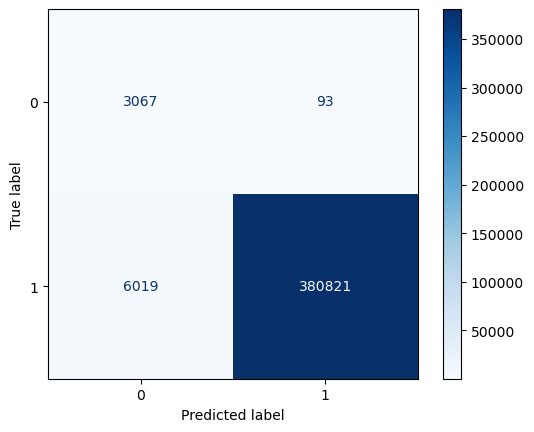

In [33]:
print(f"Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

### Random Forest

In [27]:
# ==========================================
# 1. SETUP & GRID
# ==========================================
# Random Forest Grid
param_grid = {
    'n_estimators': [100, 200],        
    'max_depth': [5, 10, 15, None],          
    'min_samples_leaf': [1, 2, 4],           
    'min_samples_split': [2, 5, 10],         
    'max_features': ['sqrt', 'log2'],
    'class_weight': [
        None,                    # Baseline: treat them as they appear
        'balanced_subsample',
        'balanced',              # Standard: helps catch the minority (but increases FPs)
        {0: 1, 1: 1.2},          # Lean toward majority (slight FP reduction)
        {0: 1, 1: 2.0},          # Strong majority bias (significant FP reduction)
        {0: 2, 1: 1.0}           # Slight minority bias (if 'balanced' is too much)
    ]
}

rf_clf = RandomForestClassifier(
    random_state=42, 
    n_jobs=1
)

# ==========================================
# 2. HYPERPARAMETER TUNING
# ==========================================
search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scoring_metrics,  # <--- Using the full metrics suite
    refit='MCC',           # <--- Optimizing for MCC
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=6,
    random_state=42
)

print("Starting Hyperparameter Tuning for Random Forest...")
search.fit(X_train, y_train)

Starting Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=1, random_state=42),
                   n_iter=20, n_jobs=6,
                   param_distributions={'class_weight': [None,
                                                         'balanced_subsample',
                                                         'balanced',
                                                         {0: 1, 1: 1.2},
                                                         {0: 1, 1: 2.0},
                                                         {0: 2, 1: 1.0}],
                                        'max_depth': [5, 10, 15, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2,...
                            'Class1_F1': make_scorer(f1_score, response_method='predict', pos_label=1),
                            'FN': make_scorer(fn_score, response_method='predict'),
                            'FP': make_scorer(fp_score, response_method='predict'),
                            'MCC': make_scorer(matthews_corrcoef, response_method='predict'),
                            'TN': make_scorer(tn_score, response_method='predict'),
                            'TP': make_scorer(tp_score, response_method='predict')},
                   verbose=1)

In [29]:
# ==========================================
# 3. SHOW TUNING RESULTS
# ==========================================
print("\n>>> TOP 5 RANDOM FOREST MODELS (Based on AUC_PR) <<<")
results = pd.DataFrame(search.cv_results_)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
rf_models_results = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

best_rf = search.best_estimator_
print(f"\nBest Params: {search.best_params_}")
rf_models_results


>>> TOP 5 RANDOM FOREST MODELS (Based on AUC_PR) <<<

Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 2, 1: 1.0}}


,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class0_F1,mean_test_Class1_F1,mean_test_TN,mean_test_FP,mean_test_TP,mean_test_FN,params
17,0.601719,0.999924,0.993051,0.585513,0.997282,634.6,716.0,164866.8,182.6,"{'n_estimators': 200, 'min_samples_split': 5, ..."
19,0.572255,0.999912,0.990147,0.548503,0.997158,570.8,779.8,164889.2,160.2,"{'n_estimators': 100, 'min_samples_split': 2, ..."
11,0.566565,0.999829,0.981451,0.558983,0.996970,634.4,716.2,164764.2,285.2,"{'n_estimators': 100, 'min_samples_split': 10,..."
18,0.546287,0.999918,0.992461,0.507813,0.997083,497.8,852.8,164937.2,112.2,"{'n_estimators': 100, 'min_samples_split': 5, ..."
10,0.536168,0.999933,0.992420,0.485913,0.992425,1174.0,176.6,162741.6,2307.8,"{'n_estimators': 200, 'min_samples_split': 5, ..."
14,0.517697,0.999906,0.989469,0.469437,0.996970,443.6,907.0,164953.6,95.8,"{'n_estimators': 100, 'min_samples_split': 10,..."
16,0.511717,0.999825,0.980977,0.476897,0.996888,469.2,881.4,164901.4,148.0,"{'n_estimators': 200, 'min_samples_split': 2, ..."
8,0.506342,0.999801,0.979255,0.464912,0.996891,446.8,903.8,164924.6,124.8,"{'n_estimators': 200, 'min_samples_split': 10,..."
1,0.480526,0.999622,0.963360,0.470301,0.996489,515.4,835.2,164724.0,325.4,"{'n_estimators': 100, 'min_samples_split': 2, ..."
15,0.466199,0.999629,0.963221,0.450435,0.996492,475.4,875.2,164764.6,284.8,"{'n_estimators': 200, 'min_samples_split': 2, ..."


In [30]:
# ==========================================
# 4. THRESHOLD TUNING (Detailed Analysis)
# ==========================================
print("\n>>> TUNING THRESHOLD ON TEST SET <<<")
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Constant metrics
model_auc_pr = average_precision_score(y_test, y_proba)
model_auc_roc = roc_auc_score(y_test, y_proba)

threshold_results = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

for thresh in thresholds:
    y_pred_loop = (y_proba >= thresh).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_loop)
    tn, fp, fn, tp = cm.ravel()
    
    threshold_results.append({
        'Threshold': thresh,
        'MCC': matthews_corrcoef(y_test, y_pred_loop),
        'AUC_PR': model_auc_pr,   
        'AUC_ROC': model_auc_roc, 
        'Class0_F1': f1_score(y_test, y_pred_loop, pos_label=0),
        'Class1_F1': f1_score(y_test, y_pred_loop, pos_label=1),
        'TN (True 0)': tn,
        'FP (Wrongly 1)': fp,
        'FN (Wrongly 0)': fn,
        'TP (True 1)': tp
    })

thresh_df = pd.DataFrame(threshold_results)
thresh_df.sort_values(by='MCC', ascending=False)


>>> TUNING THRESHOLD ON TEST SET <<<


,Threshold,MCC,AUC_PR,AUC_ROC,Class0_F1,Class1_F1,TN (True 0),FP (Wrongly 1),FN (Wrongly 0),TP (True 1)
2,0.70,0.668017,0.999919,0.992932,0.670500,0.997222,1166,522,624,205688
1,0.60,0.659729,0.999919,0.992932,0.658600,0.997472,1007,681,363,205949
3,0.80,0.652826,0.999919,0.992932,0.644912,0.996433,1334,354,1115,205197
0,0.50,0.627031,0.999919,0.992932,0.611842,0.997430,837,851,211,206101
4,0.90,0.594410,0.999919,0.992932,0.552680,0.994022,1516,172,2282,204030
5,0.95,0.509129,0.999919,0.992932,0.432777,0.989768,1595,93,4088,202224
6,0.99,0.334846,0.999919,0.992932,0.215012,0.969550,1670,18,12176,194136



 FINAL RF CONFIGURATION
 Best Threshold: 0.7
 Best MCC:       0.6680

Confusion Matrix:
True 0 (TN): 1166   False 0 (FN): 624
False 1 (FP): 522   True 1 (TP): 205688

Full Classification Report:
              precision    recall  f1-score   support

       False     0.6514    0.6908    0.6705      1688
        True     0.9975    0.9970    0.9972    206312

    accuracy                         0.9945    208000
   macro avg     0.8244    0.8439    0.8339    208000
weighted avg     0.9947    0.9945    0.9946    208000



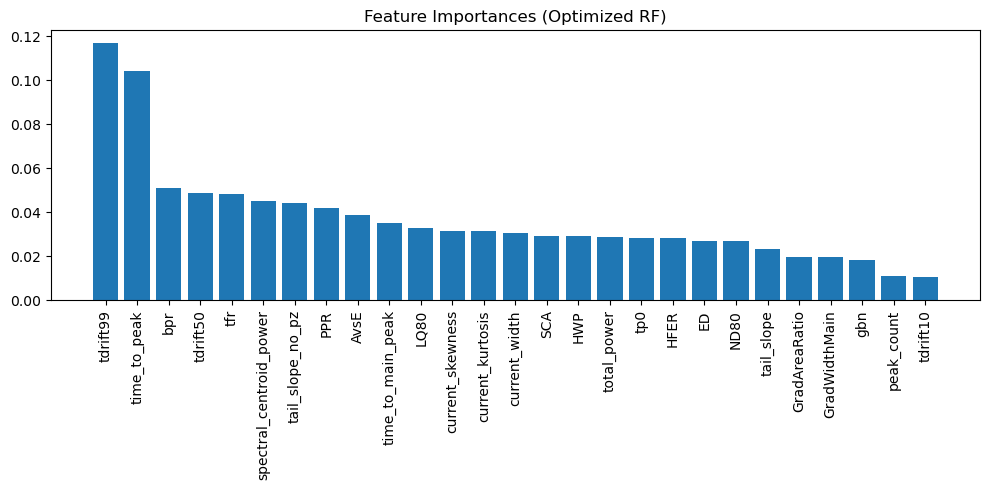

In [31]:
# ==========================================
# 5. FINAL REPORT & FEATURE IMPORTANCE
# ==========================================
# Select best threshold automatically
best_row = thresh_df.loc[thresh_df['MCC'].idxmax()]
best_threshold = best_row['Threshold']

print(f"\n" + "="*40)
print(f" FINAL RF CONFIGURATION")
print(f" Best Threshold: {best_threshold}")
print(f" Best MCC:       {best_row['MCC']:.4f}")
print("="*40)

y_final_pred = (y_proba >= best_threshold).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_final_pred)
print(f"True 0 (TN): {cm[0,0]}   False 0 (FN): {cm[1,0]}")
print(f"False 1 (FP): {cm[0,1]}   True 1 (TP): {cm[1,1]}")

print("\nFull Classification Report:")
print(classification_report(y_test, y_final_pred, digits=4))

# Plot Feature Importances
importances = best_rf.feature_importances_
# Assuming X_train is a DataFrame, use columns. If numpy array, use range.
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Optimized RF)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

### Balanced Random Forest

In [39]:
# ==========================================
# 2. SETUP MODEL & GRID
# ==========================================
# Balanced Random Forest automatically undersamples majority class per tree
brf_model = BalancedRandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    replacement=True,         # Crucial for undersampling
    sampling_strategy="all"   # 1:1 ratio in every tree
)

param_grid = {
    'n_estimators': [500, 1000],          # High tree count
    'max_depth': [10, 20, None],          # Depth control
    'min_samples_leaf': [1, 2, 4],        # Overfitting control
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None]                # BRF handles balancing internally
}

# 3-Fold CV for speed
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ==========================================
# 3. HYPERPARAMETER TUNING
# ==========================================
search = RandomizedSearchCV(
    estimator=brf_model,
    param_distributions=param_grid,
    n_iter=15,
    scoring=scoring_metrics,  # <--- Your custom list
    refit='MCC',              # <--- Optimize for MCC
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("Starting Balanced Random Forest Tuning...")
search.fit(X_train, y_train)

best_brf = search.best_estimator_
print(f"\nBest Params: {search.best_params_}")
print(f"Best CV MCC: {search.best_score_:.4f}")

Starting Balanced Random Forest Tuning...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best Params: {'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': None}
Best CV MCC: 0.4175


In [44]:
# ==========================================
# 3. STORE AND DISPLAY RESULTS
# ==========================================
print("\n>>> TOP 5 MODELS (Sorted by MCC) <<<")

# 1. Convert the raw results dictionary to a DataFrame
results = pd.DataFrame(search.cv_results_)

# 2. Define the columns you want to keep
#    Note: 'mean_test_' is the prefix Scikit-Learn adds to your custom scorer names
cols_to_show = [
    'rank_test_MCC',       # Rank
    'mean_test_MCC', 
    'mean_test_AUC_PR', 
    'mean_test_AUC_ROC',
    'mean_test_Class1_F1', # Signal F1
    'mean_test_TP',        # True Positives (Signal found)
    'mean_test_FP',        # False Positives (Background mistaken as Signal)
    'mean_test_TN',        # True Negatives
    'mean_test_FN',        # False Negatives (Signal missed)
    'params'
]

# 3. Sort, Filter, and Store in a new DataFrame variable
#    We sort by MCC because that was your refit metric
top_models_df = results.sort_values(by='mean_test_MCC', ascending=False)[cols_to_show]

# Display the top 5
top_models_df.head()


>>> TOP 5 MODELS (Sorted by MCC) <<<


,rank_test_MCC,mean_test_MCC,mean_test_AUC_PR,mean_test_AUC_ROC,mean_test_Class1_F1,mean_test_TP,mean_test_FP,mean_test_TN,mean_test_FN,params
1,1,0.417519,0.999934,0.992362,0.982698,265816.000000,93.666667,2157.333333,9266.333333,"{'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_we..."
7,2,0.416776,0.999934,0.992318,0.982641,265786.333333,94.666667,2156.333333,9296.000000,"{'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'class_wei..."
5,3,0.415846,0.999934,0.992298,0.982599,265767.000000,97.666667,2153.333333,9315.333333,"{'n_estimators': 1000, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_..."
3,4,0.415446,0.999934,0.992288,0.982531,265729.333333,96.000000,2155.000000,9353.000000,"{'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_w..."
2,5,0.410520,0.999933,0.992123,0.982039,265468.000000,96.333333,2154.666667,9614.333333,"{'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_w..."


In [45]:
# ==========================================
# 4. THRESHOLD TUNING (The Calibration)
# ==========================================
print("\n>>> TUNING THRESHOLD ON TEST SET <<<")
y_proba = best_brf.predict_proba(X_test)[:, 1]

# Constant metrics (Independent of threshold)
model_auc_pr = average_precision_score(y_test, y_proba)
model_auc_roc = roc_auc_score(y_test, y_proba)

threshold_results = []
# Added a few fine-grained steps near the top end
thresholds = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99]

for thresh in thresholds:
    # Apply Threshold
    y_pred_loop = (y_proba >= thresh).astype(int)
    
    # Calculate Counts
    cm = confusion_matrix(y_test, y_pred_loop)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate Scores
    threshold_results.append({
        'Threshold': thresh,
        'MCC': matthews_corrcoef(y_test, y_pred_loop),
        'AUC_PR': model_auc_pr,   # Constant
        'AUC_ROC': model_auc_roc, # Constant
        'Class0_F1': f1_score(y_test, y_pred_loop, pos_label=0),
        'Class1_F1': f1_score(y_test, y_pred_loop, pos_label=1),
        'TN (True 0)': tn,
        'FP (Wrongly 1)': fp,
        'FN (Wrongly 0)': fn,
        'TP (True 1)': tp
    })

# Display Threshold Table
thresh_df = pd.DataFrame(threshold_results)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

brf_results = thresh_df.sort_values(by='MCC', ascending=False)
brf_results


>>> TUNING THRESHOLD ON TEST SET <<<


,Threshold,MCC,AUC_PR,AUC_ROC,Class0_F1,Class1_F1,TN (True 0),FP (Wrongly 1),FN (Wrongly 0),TP (True 1)
0,0.50,0.427078,0.999934,0.992481,0.326301,0.983485,1624,64,6642,199670
1,0.60,0.382020,0.999934,0.992481,0.270226,0.977998,1645,43,8842,197470
2,0.70,0.335248,0.999934,0.992481,0.215845,0.969780,1666,22,12083,194229
3,0.80,0.282331,0.999934,0.992481,0.161258,0.955858,1677,11,17434,188878
4,0.85,0.250286,0.999934,0.992481,0.131888,0.943404,1679,9,22094,184218
5,0.90,0.215153,0.999934,0.992481,0.102905,0.923541,1681,7,29302,177010
6,0.95,0.170056,0.999934,0.992481,0.071143,0.880722,1684,4,43969,162343
7,0.99,0.101765,0.999934,0.992481,0.036193,0.722280,1684,4,89684,116628


### Final Comparison
#### compare each best model using actual test dataset after training them on the entire full train dataset

In [33]:
print(f"Final Training Shape: {X.shape}")
print(f"Final Test Shape:     {X_test_final.shape}")

Final Training Shape: (1040000, 27)
Final Test Shape:     (390000, 27)


In [ ]:
# ==========================================
# 2. RETRAIN MODEL WITH BEST PARAMS
# ==========================================
# We unpack the best parameters found by RandomizedSearchCV
final_model = xgb.XGBClassifier(
    **search.best_params_,  # Uses the winner from the previous step
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

print("\nRetraining model on full dataset...")
final_model.fit(X, y_train_full)

# ==========================================
# 3. PREDICT ON FINAL HELD-OUT SET
# ==========================================
# Get probabilities for the final test set
y_final_proba = final_model.predict_proba(X_test_final)[:, 1]

# Apply the BEST THRESHOLD found in the previous step
# (If you didn't run the loop, set this manually, e.g., best_threshold = 0.95)
print(f"\nApplying Best Threshold: {best_threshold}")
y_final_pred = (y_final_proba >= best_threshold).astype(int)